## Basic examples using the tools in pyrtools
### Content
- Load an image, and downsample to a size appropriate for the machine speed
- Synthetic images ('ramp', 'impulse', etc.)
- Point operations (lookup tables)
- histogram Modification/matching
- Convolution routines
- Compare speed of convolution/downsampling routines
- Handling of left and top boundaries ('reflect1', 'reflect2', 'repeat', 'extend', 'zero', 'circular', 'dont-compute')

for multi-scale pyramids see `TUTORIALS/02_pyramids.ipynb`  
for multi-scale steerable pyramids see `TUTORIALS/03_steerable_pyramids.ipynb`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyrtools as pt

%load_ext autoreload
%autoreload 2

## Load an image, and downsample to a size appropriate for the machine speed

In [2]:
oim = plt.imread('../DATA/einsteinCorrect.pgm').astype(float)

In [3]:
imSubSample = 1
im = pt.blurDn(oim, n_levels=imSubSample, filt='qmf9')

ShowIm: 3 types of automatic graylevel scaling, 2 types of automatic sizing, with or without title and Range information.

In [4]:
? pt.imshow

Signature:
 pt.imshow(
    ['image', "vrange='indep1'", 'zoom=1', "title=''", 'col_wrap=None', 'ax=None', 'cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7fa740350278>', "plot_complex='rectangular'", '**kwargs'],
)
Docstring:
show image(s)

Parameters
----------
img: 2d array (one image to display), 3d array (multiple images to display, images are indexed
along the first dimension), or list of 2d arrays. the image(s) to be shown. all images will be
automatically rescaled so they're displayed at the same size. thus, their sizes must be scalar
multiples of each other.

vrange: A list of two numbers, or a string. If two numbers, these specify the image values 
         vmin/vmax that are mapped to black/white, respectively. If a string:
- auto/auto1: all images have same vmin/vmax, which are the minimum/maximum values across all
              images
- auto2: all images have same vmin/vmax, which are the mean (across all images) minus/plus 2
         std dev (across all images

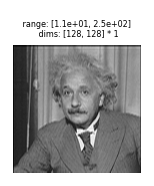

In [5]:
pt.imshow(im);

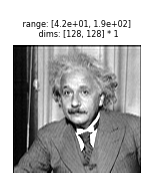

In [6]:
pt.imshow(im, vrange='auto2');
# TODO
# pt.imshow([oim,im], zoom=[1,2], title=['original', 'subsampled'], vrange='auto2', col_wrap=2);

In [7]:
# TODO
# plt.figure(figsize=(15,15))
# ax1 = plt.subplot(1,2,1)
# ax2 = plt.subplot(1,2,2)
# pt.imshow(im, ax= ax1)
# pt.imshow(oim, ax= ax2);

## Statistics:

In [8]:
pt.image_stats(im);
pt.image_compare(im, oim);

Image statistics:
  Range: [11.270653, 253.768820]
  Mean: 116.714109,  Stdev: 37.529870,  Kurtosis: 3.150887
Error: input images must have the same size


## Synthetic images

In [9]:
# pick some parameters
size      = 256
direction = 2 * np.pi * np.random.rand(1)
slope     = 10 * np.random.rand(1) - 5
intercept = 10 * np.random.rand(1) - 5
origin    = np.round(size * np.random.rand(2,1)).astype(int)
exponent  = 0.8 + np.random.rand(1)
amplitude = 1 + 5 * np.random.rand(1)
phase     = 2 * np.pi * np.random.rand(1)
period    = 20
twidth    = 7

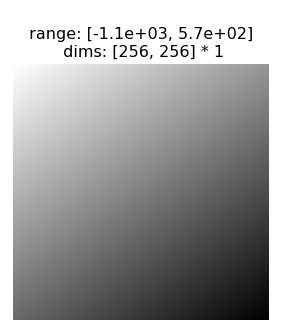

In [10]:
pt.imshow(pt.synthetic_images.ramp(size, direction, slope, intercept, origin));

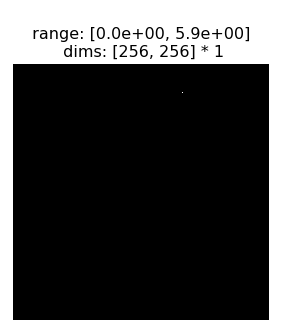

In [11]:
pt.imshow(pt.synthetic_images.impulse(size, origin, amplitude));

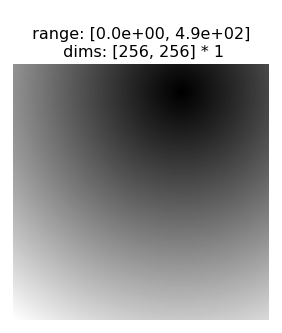

In [12]:
pt.imshow(pt.synthetic_images.polar_radius(size, exponent, origin));

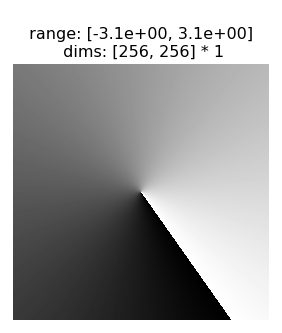

In [13]:
pt.imshow(pt.synthetic_images.polar_angle(size, direction));

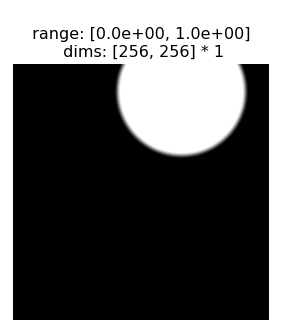

In [14]:
pt.imshow(pt.synthetic_images.disk(size, size/4, origin, twidth));

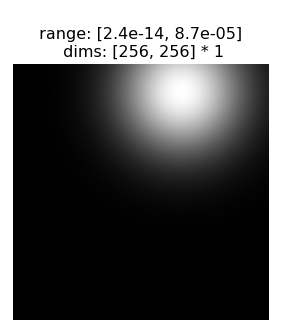

In [15]:
pt.imshow(pt.synthetic_images.gaussian(size, (size/6)**2, origin, 'norm'));

In [16]:
# TODO fix normalization - range
g = pt.synthetic_images.gaussian(size, (size/6)**2, origin, 'norm')
g.min(), g.max()

(2.3671652181583967e-14, 8.742642137616321e-05)

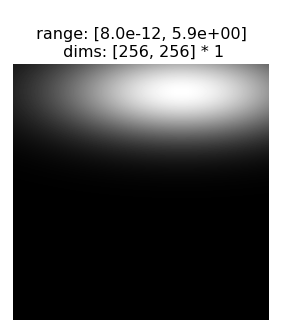

In [17]:
pt.imshow(pt.synthetic_images.gaussian(size, ((size/8)**2,(size/3)**2), origin, amplitude));

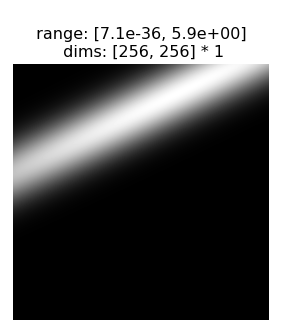

In [18]:
# cov = (size * np.random.uniform(-1,1,(2,2)))
# cov = cov.dot(cov.T)
# print(np.round(cov))
cov = np.array((( 12571., -25233.),
                (-25233.,  52488.)))

pt.imshow(pt.synthetic_images.gaussian(size, cov, origin, amplitude));

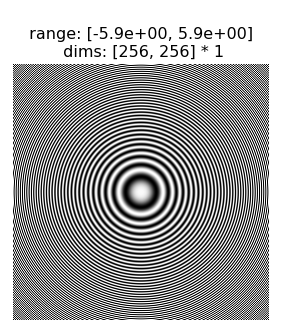

In [19]:
fig=pt.imshow(pt.synthetic_images.zone_plate(size, amplitude, phase));
fig.savefig('zoneplate.png')

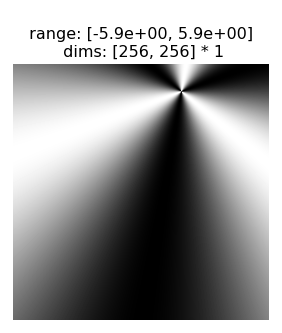

In [20]:
pt.imshow(pt.synthetic_images.angular_sine(size, 3, amplitude, phase, origin));

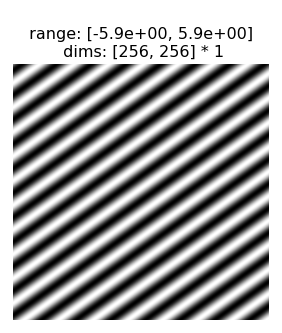

In [21]:
pt.imshow(pt.synthetic_images.sine(size, period, direction, amplitude=amplitude, phase=phase, origin=origin));

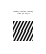

In [22]:
pt.imshow(pt.synthetic_images.sine(20, frequency=[1,2]));

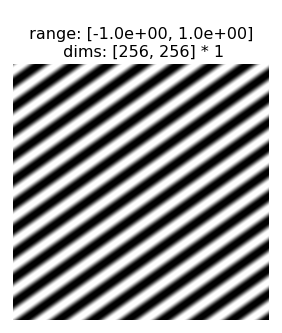

In [23]:
pt.imshow(pt.synthetic_images.square_wave(size, period, direction, amplitude, phase=phase, origin=origin, twidth=twidth));

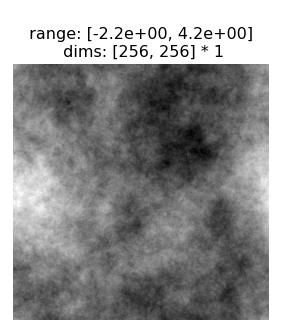

In [24]:
pt.imshow(pt.synthetic_images.pink_noise(size, exponent));

In [25]:
# TODO
## Plotting complex valued images

# pt.imshow(im);

# sp = np.log2(np.fft.fftshift(np.fft.fft2(im, norm='ortho')))

# pt.imshow(sp, plot_complex='polar');

## Point operations (lookup tables):

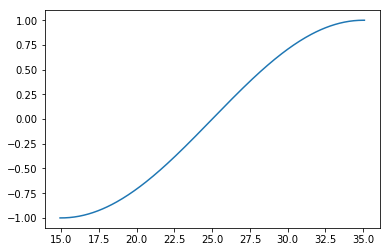

In [26]:
Xtbl,Ytbl = pt.rcosFn(width=20, position=25, values=(-1, 1))
plt.plot(Xtbl,Ytbl)
plt.show()

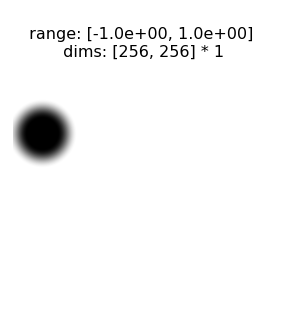

In [27]:
pt.imshow(pt.pointOp(pt.synthetic_images.polar_radius(size,1,[70,30]), Ytbl, Xtbl[0], Xtbl[1]-Xtbl[0], 0));

## Convolution routines: Compare speed of convolution/downsampling routines

In [28]:
k = 5
size = 2 ** 9
noise = np.random.rand(size,size)
filt  = np.random.rand(k,k)

In [29]:
%%time
res1 = pt.corrDn(noise, np.flipud(np.fliplr(filt)), 'reflect1', step=[2, 2])

CPU times: user 0 ns, sys: 15.1 ms, total: 15.1 ms
Wall time: 4.85 ms


In [30]:
%%time
ires = pt.rconv2(noise,filt)
res2 = ires[0:size:2,0:size:2]

CPU times: user 30.7 ms, sys: 58.4 ms, total: 89.1 ms
Wall time: 29.6 ms


In [31]:
pt.image_compare(res1, res2);

Difference statistics:
  Range: [0, 0]
  Mean: -0.000000,  Stdev (rmse): 0.000000,  SNR (dB): 294.721265


In [32]:
res3 = pt.corrDn(noise, np.flipud(np.fliplr(filt)), 'reflect1', step=[1, 1])
pt.image_compare(res3, ires);

Difference statistics:
  Range: [0, 0]
  Mean: -0.000000,  Stdev (rmse): 0.000000,  SNR (dB): 294.635852


In [33]:
im = plt.imread('../DATA/einsteinCorrect.pgm').astype(float)
# im = pt.synthetic_images.impulse(256, origin=None)

In [34]:
binom5 = pt.binomial_filter(5)
# construct a separable 2D filter
lo_filt = 2*binom5*binom5.T   

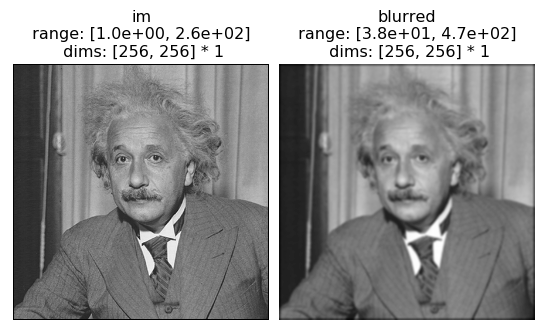

In [35]:
blurred = pt.rconv2(im, lo_filt) 
pt.imshow([im, blurred], title=['im', 'blurred']);

In [36]:
# much faster implementation:
b = pt.corrDn(im, np.flipud(np.fliplr(lo_filt)), 'reflect1', step=[1, 1])
pt.image_compare(blurred, b);

# each dimension separately
bx  = pt.corrDn(im, binom5.T, 'reflect1')
bxy = pt.corrDn(bx, binom5, 'reflect1')
bxy *= 2
pt.image_compare(bxy, b);

Difference statistics:
  Range: [0, 0]
  Mean: -0.000000,  Stdev (rmse): 0.000000,  SNR (dB): 306.632861
Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): inf


In [37]:
# TODO explain the source of these small differences

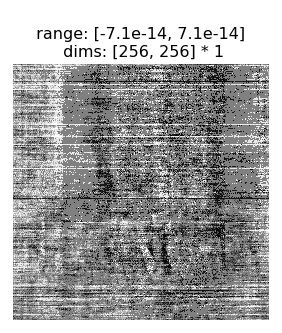

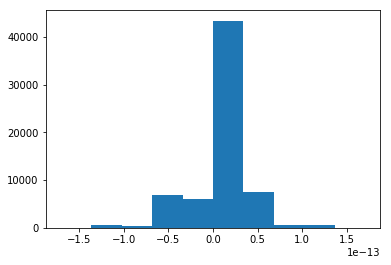

In [38]:
diff = b-blurred
pt.imshow(diff, vrange='auto3');
plt.figure()
plt.hist(diff.flatten())
plt.show()

Difference statistics:
  Range: [0, 0]
  Mean: 0.000000,  Stdev (rmse): 0.000000,  SNR (dB): inf


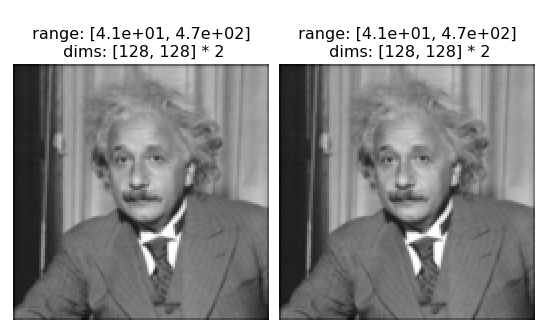

In [39]:
# blur and downsample in a single step
blurred1 = pt.corrDn(image = im, filt = lo_filt, step = (2,2))

bx  = pt.corrDn(im, binom5.T, 'reflect1', step=[1, 2])
bxy = pt.corrDn(bx, binom5, 'reflect1', step=[2, 1])
bxy *= 2

pt.imshow([blurred1, bxy], zoom=2);
pt.image_compare(blurred1, bxy);

In [40]:
# TODO
# also compare to to scipy.signal solution

import scipy.signal as sps

res4 = sps.convolve2d(noise, filt, mode='same', boundary='symm')

pt.image_compare(res4, ires);

Difference statistics:
  Range: [-2, 2]
  Mean: -0.000676,  Stdev (rmse): 0.077196,  SNR (dB): 21.689682


In [41]:
# TODO decide on subsampling depending on machine speed

import time
t = time.time()
pt.corrDn(oim, filt=np.ones((2,2)) / 4, edges='reflect1', step=(2, 2), start=(0, 0), stop=None)
elapsed = time.time() - t
imSubSample = min(max(np.floor(np.log2(elapsed)/2+3),0),2)
imSubSample

0

## Handling of left and top boundaries:

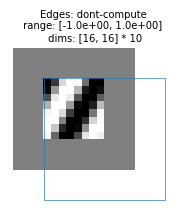

In [42]:
fsz = [9, 9]
fmid = np.ceil((fsz[0]+1)/2)
imsz = (16, 16)

# pick one:
im = np.eye(imsz[0])
im = pt.synthetic_images.ramp(imsz, np.pi/6)
im = pt.synthetic_images.square_wave(imsz, 6, np.pi/6)

# pick one:
edges='reflect1'
edges='reflect2'
edges='repeat'
edges='extend'
edges='zero'
edges='circular'
edges='dont-compute'

filt = pt.synthetic_images.impulse(fsz,[0, 0])
pt.imshow(pt.corrDn(im,filt,edges), zoom=10, title='Edges: ' + str(edges))
# TODO
plt.plot([0,0,imsz[1],imsz[1],0]+fmid-1.5,
         [0,imsz[0],imsz[0],0,0]+fmid-1.5, lw=.5)
plt.show()